<a href="https://colab.research.google.com/github/avocadopelvis/BTP/blob/main/brain-tumor-segmentation/bts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# neural imaging
!pip install nilearn
# nifti to gif 
!pip install git+https://github.com/miykael/gif_your_nifti 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-3dg6b5wa
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-3dg6b5wa
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.0-py3-none-any.whl size=6270 sha256=6c980da6b69a404747f062e34cd5e2c4157211f6814973c451beefb188f130f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wpuprv4m/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti


### LOAD LIBRARIES

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
import cv2
# glob (short for global) is used to return all file paths that match a specific pattern.
import glob 

# PIL adds image processing capabilities to your Python interpreter.
import PIL
from PIL import Image, ImageOps

# Shutil module offers high-level operation on a file like a copy, create, and remote operation on the file.
import shutil

# skimage is a collection of algorithms for image processing and computer vision.
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize


# NEURAL IMAGING
import nilearn as nl
import nibabel as nib # access a multitude of neuroimaging data formats
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif


# ML Libraries
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

# make numpy printouts easier to read
np.set_printoptions(precision = 3, suppress = True)

import warnings
warnings.filterwarnings('ignore')

In [5]:
# define segmentation areas
SEGMENT_CLASSES = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING TUMOR CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# ????????
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [6]:
# dataset path
train_data = "/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/DATASET/BraTS 2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
valid_data = "/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/DATASET/BraTS 2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

Text(0.5, 1.0, 'Mask')

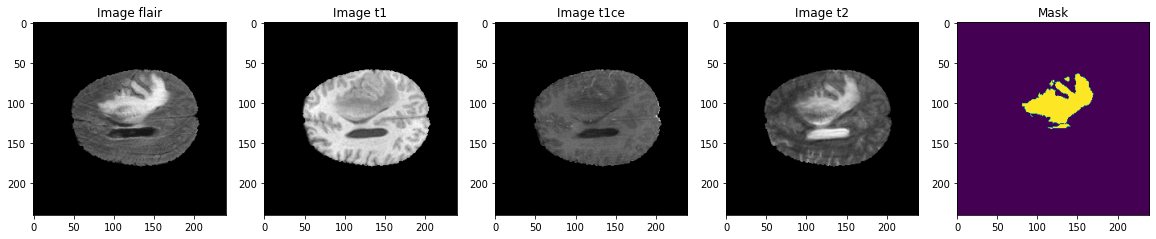

In [7]:
test_image_flair = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))
slice_w = 25

# FLAIR
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')

# T1
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')

# T1CE
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')

# T2
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')

# MASK
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

### DISPLAY WHOLE NFTI DATA -> PRINT EACH SLICE FROM 3D DATA

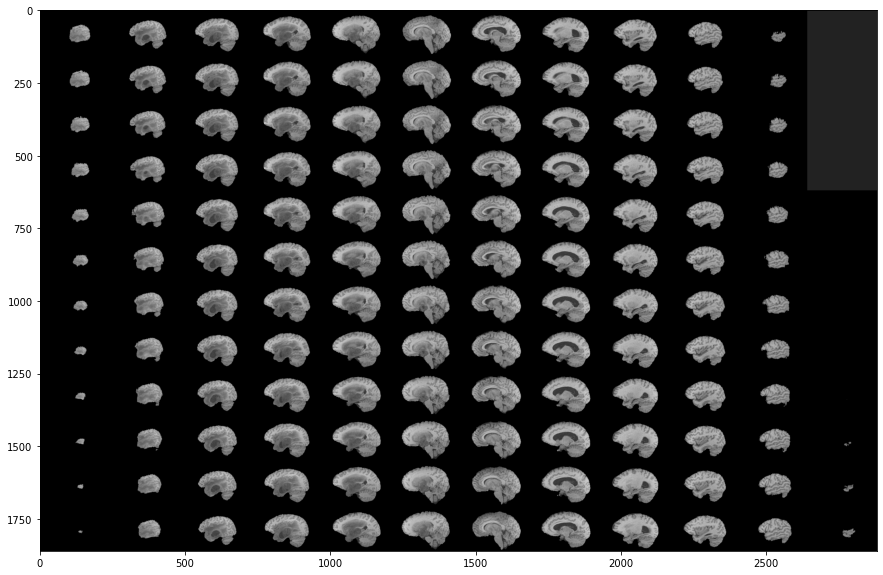

In [8]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize = True), cmap = 'gray')

### SEGMENT OF TUMOR FOR EACH ABOVE SLICE

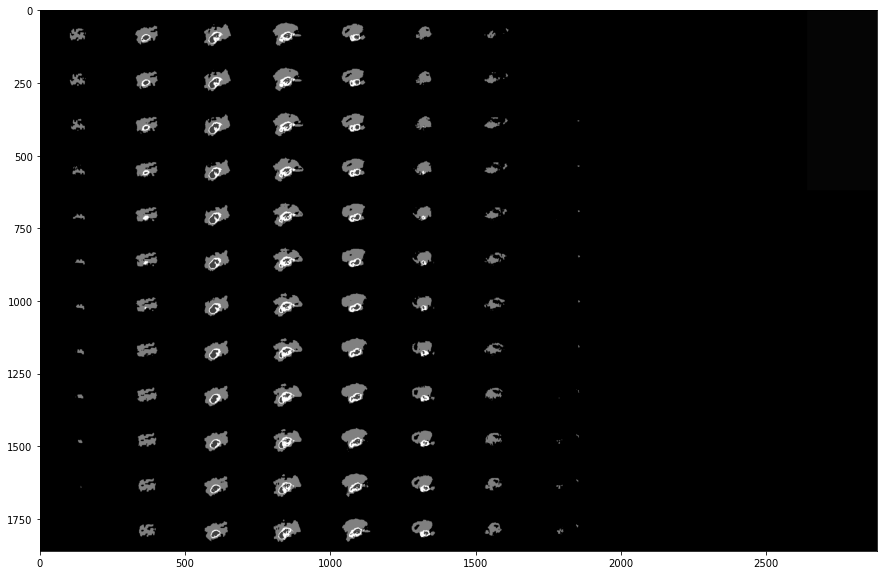

In [9]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_mask[50:-50,:,:]), 90, resize = True), cmap = 'gray')

### GIF REPRESENTATION OF SLICES IN 3D VOLUME

In [10]:
# # make a copy of flair image
# shutil.copy2(train_data + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
# # convert flair image into gif
# gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')
# # both copy and gif will be saved in output

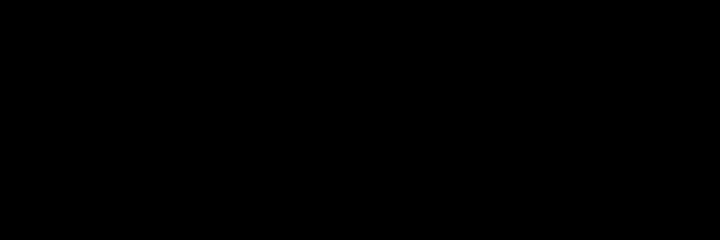

In [11]:
from IPython.display import Image
Image(open('/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/test_gif_BraTS20_Training_001_flair.gif','rb').read())

### SEGMENT OF TUMORS USING DIFFERENT EFFECTS

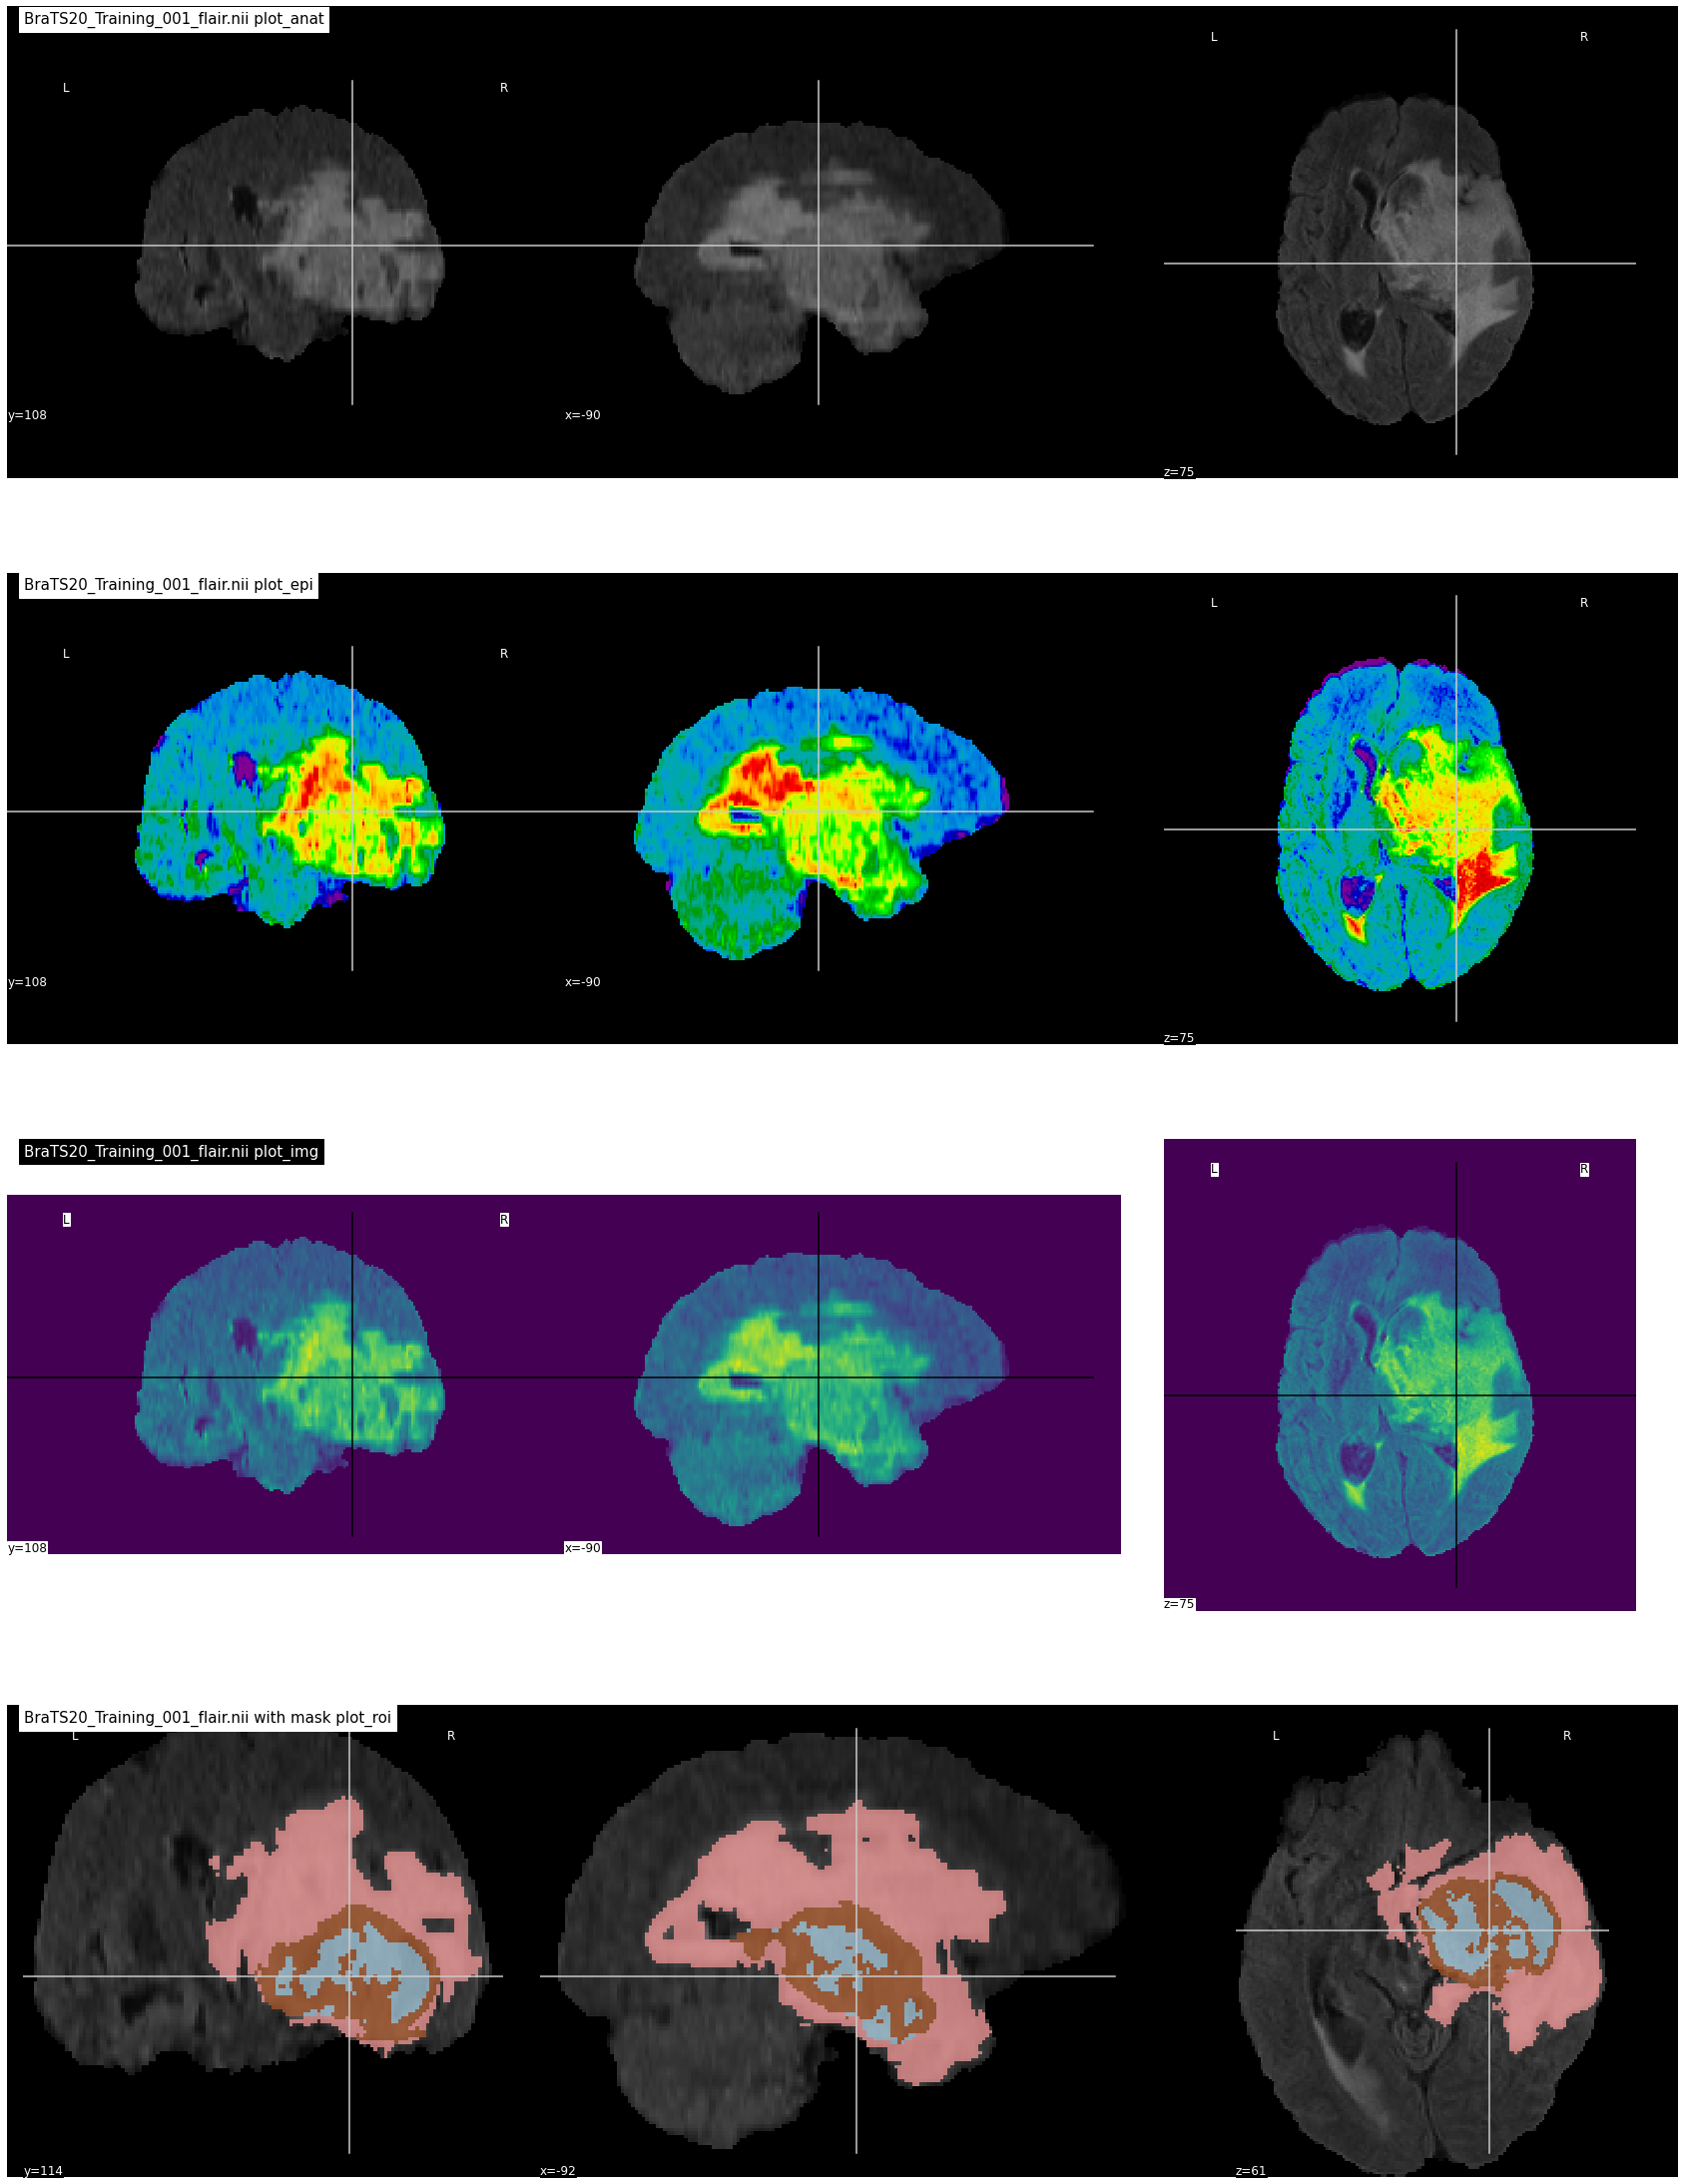

In [12]:
niimg = nl.image.load_img(train_data + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(train_data + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows = 4, figsize = (30, 40))

# plot cuts of an anatomical image
nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

# plot cuts of an EPI (echo-planar imaging) image
nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])


# plot cuts of a given image 
nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

# plot cuts of region of interest (ROI) in a given image
nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [13]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [14]:
# pip install keras-unet-collection

In [15]:
# from keras_unet_collection import models

# U-NET
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

In [16]:
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]
)

### LOAD DATA

In [17]:
# list of directories
train_val_directories = [f.path for f in os.scandir(train_data) if f.is_dir()]

# remove BraTS20_Training_355 since it has ill formatted name for seg.nii file
train_val_directories.remove(train_data + 'BraTS20_Training_355')

# function to convert list of paths into IDs
def pathListIntoIDs(dirList):
  x = []
  for i in range(0, len(dirList)):
    x.append(dirList[i][dirList[i].rfind('/')+1:])
  return x

ids = pathListIntoIDs(train_val_directories)

# split ids into train+test and validation
train_test_ids, val_ids = train_test_split(ids, test_size = 0.2)
# split train+test into train and test                                           
train_ids, test_ids = train_test_split(train_test_ids, test_size = 0.15)

No handles with labels found to put in legend.


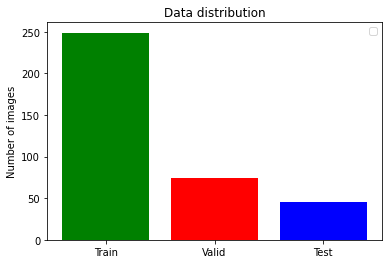

In [18]:
# function to display data distribution
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [19]:
# override keras sequence DataGenerator class
class DataGenerator(keras.utils.Sequence):
    # generates data for Keras
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        # Initialization
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # generate one batch of data

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        # updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_data, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

In [20]:
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [21]:
# add callback for training process
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

### TRAIN MODEL

In [22]:
# K.clear_session()

# history =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  

# # save the model
# model.save("model.h5")

In [23]:
# load trained model
model = keras.models.load_model("/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/model.h5",
                                custom_objects = {'accuracy' : tf.keras.metrics.MeanIoU(num_classes = 4),
                                                  'dice_coef' : dice_coef,
                                                  'precision' : precision,
                                                  'sensitivity' : sensitivity,
                                                  'specificity' : specificity,
                                                  'dice_coef_necrotic' : dice_coef_necrotic,
                                                  'dice_coef_edema' : dice_coef_edema,
                                                  'dice_coef_enhancing' : dice_coef_enhancing
                                                  }, compile = False)

# load training history
history = pd.read_csv("/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/training.log", sep = ',', engine = 'python')

acc = history['accuracy']
val_acc = history['val_accuracy']

epoch = range(len(acc))

loss = history['loss']
val_loss = history['val_loss']

dice = history['dice_coef']
val_dice = history['val_dice_coef']

mean_iou = history['mean_io_u']
val_mean_iou = history['val_mean_io_u']

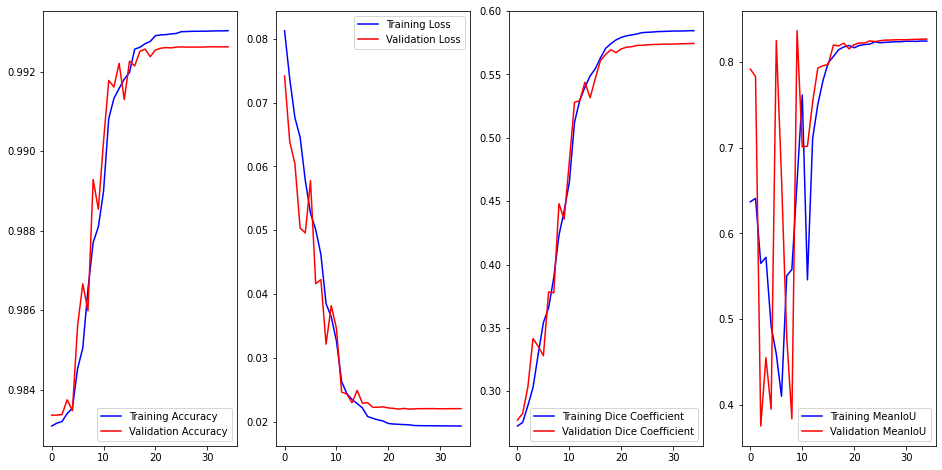

In [24]:
# visualize the training process

f, ax = plt.subplots(1, 4, figsize = (16, 8))

# ACCURACY
ax[0].plot(epoch, acc, 'b', label = 'Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label = 'Validation Accuracy')
ax[0].legend()

# LOSS
ax[1].plot(epoch, loss, 'b', label = 'Training Loss')
ax[1].plot(epoch, val_loss, 'r', label = 'Validation Loss')
ax[1].legend()

# DICE COEFFICIENT
ax[2].plot(epoch, dice, 'b', label = 'Training Dice Coefficient')
ax[2].plot(epoch, val_dice, 'r', label = 'Validation Dice Coefficient')
ax[2].legend()

# Mean IoU
ax[3].plot(epoch, mean_iou, 'b', label = 'Training MeanIoU')
ax[3].plot(epoch, val_mean_iou, 'r', label = 'Validation MeanIoU')
ax[3].legend()

plt.show()

### PREDICTIONS

In [25]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/DATASET/BraTS 2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

4/4 [==============================] - 13s 289ms/step


<Figure size 1296x3600 with 0 Axes>

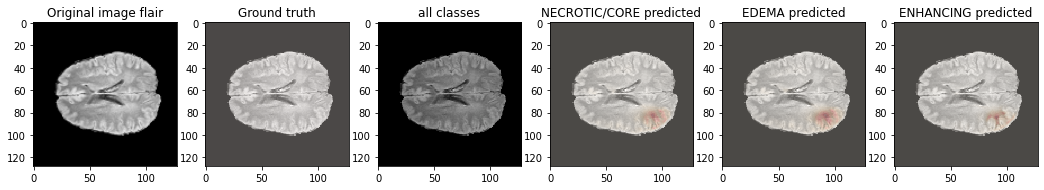

In [26]:
showPredictsById(case = test_ids[0][-3:])

4/4 [==============================] - 0s 75ms/step


<Figure size 1296x3600 with 0 Axes>

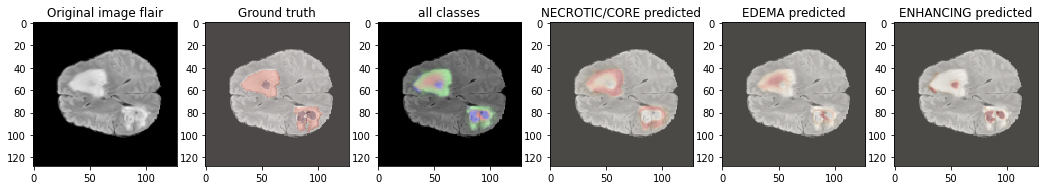

In [27]:
showPredictsById(case=test_ids[1][-3:])

4/4 [==============================] - 0s 81ms/step


<Figure size 1296x3600 with 0 Axes>

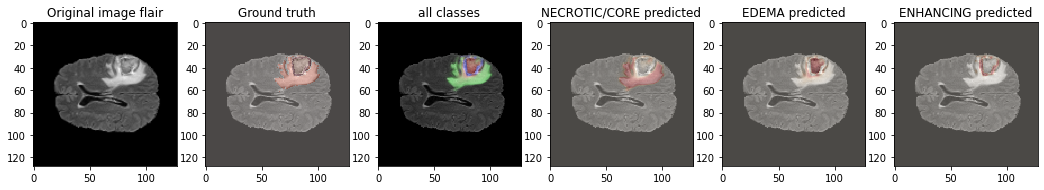

In [28]:
showPredictsById(case=test_ids[2][-3:])

4/4 [==============================] - 0s 80ms/step


<Figure size 1296x3600 with 0 Axes>

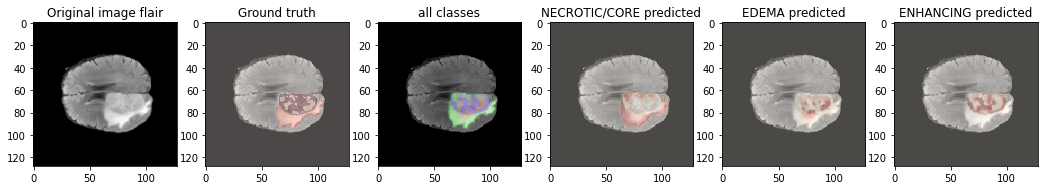

In [29]:
showPredictsById(case=test_ids[3][-3:])

### EVALUATION

4/4 [==============================] - 0s 77ms/step


<Figure size 432x288 with 0 Axes>

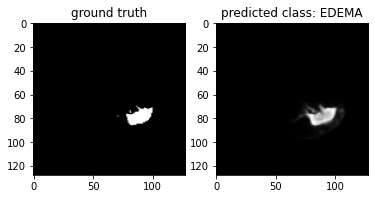

In [31]:
case = test_ids[3][-3:]
path = f"/content/drive/MyDrive/BTP/BRAIN TUMOR SEGMENTATION/DATASET/BraTS 2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"

# ground truth
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

p = predictByPath(path, case)

core = p[:, :, :, 1]
edema = p[:, :, :, 2]
enhancing = p[:, :, :, 3]

# slice at
i = 40
eval_class = 2

# use only one class for per class evaluation 
gt[gt != eval_class] = 1

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [33]:
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

print("Evaluate on test data:")
results = model.evaluate(test_generator, batch_size = 100, callbacks = callbacks)

Evaluate on test data
45/45 [==============================] - 99s 2s/step - loss: 0.0221 - accuracy: 0.9920 - mean_io_u_2: 0.8193 - dice_coef: 0.5928 - precision: 0.9931 - sensitivity: 0.9899 - specificity: 0.9976 - dice_coef_necrotic: 0.5418 - dice_coef_edema: 0.7376 - dice_coef_enhancing: 0.6558
Test Loss, Test Accuracy:  [0.02207024395465851, 0.9919872879981995, 0.8192756772041321, 0.5927679538726807, 0.993068277835846, 0.9898902773857117, 0.9976452589035034, 0.5418402552604675, 0.737596869468689, 0.6558069586753845]


In [34]:
print("Test Loss, Test Accuracy: ", results)

Test Loss, Test Accuracy:  [0.02207024395465851, 0.9919872879981995, 0.8192756772041321, 0.5927679538726807, 0.993068277835846, 0.9898902773857117, 0.9976452589035034, 0.5418402552604675, 0.737596869468689, 0.6558069586753845]
